In [14]:
import tensorflow as tf
import keras
import os
import cv2
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from skimage.metrics import structural_similarity as ssim
from keras.models import load_model, Model
from scipy.stats import gaussian_kde
from keras import Input
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from keras.layers import Conv2D, MaxPooling2D, Resizing, UpSampling2D, Dense, BatchNormalization, Add, Flatten, Reshape, add, LeakyReLU, ZeroPadding2D
from keras.models import Sequential
from keras.optimizers import SGD, Adam


In [ ]:
def loss_ssim(y_true, y_pred):
    # Calculer le data_range
    data_range = tf.reduce_max(y_true) - tf.reduce_min(y_true)
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=data_range))

In [ ]:
def residual_block_Gui(x, filters, kernel_size=3, is_encoder=True):
    shortcut = x
    # Convolutions
    x = Conv2D(filters, kernel_size, activation='relu', padding='same', use_bias=False)(x)
    x = MaxPooling2D((2,2), padding='same')(x) if is_encoder else UpSampling2D(2)(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters, kernel_size, strides=1, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)

    shortcut = Conv2D(filters, kernel_size, activation='relu', padding='same', use_bias=False)(shortcut)
    shortcut = MaxPooling2D((2,2), padding='same')(shortcut) if is_encoder else UpSampling2D(2)(shortcut)
    shortcut = BatchNormalization()(shortcut)

    x = add([x, shortcut])
    return x

In [2]:
def generator_to_array(generator):
    # Initialiser une liste pour stocker les échantillons
    num_samples = len(generator)
    samples = []
    # Itérer sur le générateur pour obtenir les échantillons
    for i in range(num_samples):
        batch = generator.next()
        for image in batch[0]:
            samples.append(image)  # Ajouter uniquement les données (ignorer les étiquettes)
    return np.array(samples)

def mean_cosinus_similarity(v1, v2):
    cosinus_similarity = 0
    nb_individus = v1.shape[0]
    for i in range(nb_individus):
        cosinus_similarity += np.dot(v1[i], v2[i]) / (np.linalg.norm(v1[i]) * np.linalg.norm(v2[i]))
    return cosinus_similarity/nb_individus

def calculate_mean_dispersion(latent_representations):
    centroid = np.mean(latent_representations, axis=0)
    distance_squared = np.sum((latent_representations - centroid)**2, axis = 1)
    return np.mean(distance_squared)

def comparaison_visages(asian, asian_predict, white, white_predict, ethnie):

    plt.figure(figsize=(15, 6))

    # Affichage des images du premier trainset
    plt.subplot(2, 5, (1, 5))
    plt.axis("off")
    plt.title('Caucasiens')
    for i in range(5):
        plt.subplot(2, 5, i + 1)
        plt.imshow(white[i], cmap='gray')
        plt.axis('off')
        plt.subplot(2, 5, i + 6)
        plt.imshow(white_predict[i], cmap='gray')
        plt.axis('off')

    # Titre global
    plt.suptitle(f'Comparaison des images d entrées et de sorties caucasiennes d espace latent {ethnie}')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(15, 6))

    # Affichage des images du premier trainset
    plt.subplot(2, 5, (1, 5))
    plt.axis("off")
    plt.title('Asiatiques')
    for i in range(5):
        plt.subplot(2, 5, i + 1)
        plt.imshow(asian[i], cmap='gray')
        plt.axis('off')
        plt.subplot(2, 5, i + 6)
        plt.imshow(asian_predict[i], cmap='gray')
        plt.axis('off')

    # Titre global
    plt.suptitle('Comparaison des images d entrées et de sorties asiatiques')
    plt.tight_layout()
    plt.show()

def pca(latent_asian, latent_white, ethnie):
    pca = PCA(n_components=2)
    latent_pca_white = pca.fit_transform(latent_white)
    latent_pca_asian = pca.fit_transform(latent_asian)
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(latent_pca_white[:, 0], latent_pca_white[:, 1], color='r', alpha=0.5, label='white_predict')
    scatter_b = plt.scatter(latent_pca_asian[:, 0], latent_pca_asian[:, 1], color='b', alpha=0.5, label='asian_predict')
    plt.legend(handles=[scatter, scatter_b])
    plt.title(f'Projection ACP de l espace latent {ethnie}')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

    return np.concatenate([latent_pca_white, latent_pca_asian], axis=0)


def cosinus_similarity(asian_flatten, asian_predict_flatten, white_flatten, white_predict_flatten):
    asian_cs = mean_cosinus_similarity(asian_flatten, asian_predict_flatten)
    white_cs = mean_cosinus_similarity(white_flatten, white_predict_flatten)
    print(f"Moyenne des similarités cosinus pour les individus caucasiens : {white_cs}")
    print(f"Moyenne des similarités cosinus pour les individus asiatiques : {asian_cs}")
    
def comparaison_dispersion(latent_asian, latent_white):
    asian_mean_dispersion = calculate_mean_dispersion(latent_asian)
    white_mean_dispersion = calculate_mean_dispersion(latent_white)
    print(f"Moyenne des dispersions des espaces latents pour les individus caucasiens : {white_mean_dispersion}")
    print(f"Moyenne des dispersions des espaces latents pour les individus asiatiques : {asian_mean_dispersion}")

def coef_bhattacharyya(latent_asian, latent_white):
    normalize_a = tf.nn.l2_normalize(np.mean(latent_asian, axis=0),axis=0)        
    normalize_b = tf.nn.l2_normalize(np.mean(latent_white, axis=0),axis=0)
    return tf.reduce_sum(tf.multiply(normalize_a,normalize_b))

def ssim_mean(ytrue, ypred, length):    
    res = 0
    for i in range(length):
        res+=ssim(ytrue[i], ypred[i], data_range=ytrue[i].max() - ytrue[i].min(), multichannel=False)
    
    return res/length

def structure_ssim(ytrue, ypred):
    return ssim(ytrue, ypred, data_range=ytrue.max() - ytrue.min(), multichannel=False)

In [13]:
def create_model(input_shape=(150, 150, 1), input_latent=512):
    inputs = Input(shape=input_shape)

    x = layers.ZeroPadding2D(padding=2)(inputs)
    x = Conv2D(8, 5, strides=2, padding='valid')(inputs)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    
    x = Conv2D(16, 5, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    
    x = Conv2D(32, 5, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    skip_3 = Conv2D(4, 5, strides=1, padding='same')(x)

    x = Conv2D(64, 5, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    skip_4 = Conv2D(4, 5, strides=1, padding='same')(x)

    x = Conv2D(128, 5, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    skip_5 = Conv2D(4, 5, padding='same')(x)

    x = Conv2D(256, 5, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)

    print(x.shape, "latent_space")

    x = tf.nn.depth_to_space(x, 2)
    x = tf.concat([x, skip_5], 1)
    x = Conv2D(128, 5, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)

    x = tf.nn.depth_to_space(x, 2)
    x = tf.concat([x, skip_4], 1)
    x = Conv2D(64, 5, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)

    x = tf.nn.depth_to_space(x, 2)
    x = tf.concat([x, skip_3], 1)
    x = Conv2D(32, 5, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)

    x = tf.nn.depth_to_space(x, 2)
    x = Conv2D(16, 5, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)

    x = tf.nn.depth_to_space(x, 2)
    x = Conv2D(16, 5, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)

    x = tf.nn.depth_to_space(x, 2)
    x = Conv2D(3, 5, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Sigmoid()(x)

    model.add(Resizing(height=input_shape[0], width=input_shape[1], name='recon_image'))
    model.compile(optimizer='adam',loss='mean_squared_error',metrics=['accuracy'])

    model.summary()
    return model

model = create_model()

(None, 3, 3, 256) latent_space


ValueError: Exception encountered when calling layer "tf.concat_1" (type TFOpLambda).

Dimension 0 in both shapes must be equal, but are 6 and 5. Shapes are [6,64] and [5,4]. for '{{node tf.concat_1/concat}} = ConcatV2[N=2, T=DT_FLOAT, Tidx=DT_INT32](Placeholder, Placeholder_1, tf.concat_1/concat/axis)' with input shapes: [?,6,6,64], [?,5,5,4], [] and with computed input tensors: input[2] = <1>.

Call arguments received by layer "tf.concat_1" (type TFOpLambda):
  • values=['tf.Tensor(shape=(None, 6, 6, 64), dtype=float32)', 'tf.Tensor(shape=(None, 5, 5, 4), dtype=float32)']
  • axis=1
  • name=concat

In [ ]:
def create_autoencodeur(input_shape=(150, 150, 1), input_latent=512):

    np.random.seed(42)
    model=Sequential()

    model.add(Conv2D(64, (3,3),activation='relu',padding='same', input_shape=(input_shape)))
    model.add(MaxPooling2D((2,2), padding='same'))
    model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2,2), padding='same'))
    model.add(Conv2D(16, (3,3),activation='relu',padding='same'))
    model.add(MaxPooling2D((2,2), padding='same'))
    
    #model.add(Dense(input_latent, activation='relu'))

    model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
    model.add(UpSampling2D((2,2)))
    model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
    model.add(UpSampling2D((2,2)))
    model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(UpSampling2D((2,2)))

    model.add(Conv2D(1, (3,3), activation='relu', padding='same'))

    model.add(Resizing(height=input_shape[0], width=input_shape[1], name='recon_image'))
    model.compile(optimizer='adam',loss='mean_squared_error',metrics=['accuracy'])

    model.summary()
    return model
model = create_autoencodeur(input_shape=(300, 300, 1), input_latent=1)

In [ ]:
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, BatchNormalization, LeakyReLU, Dropout, Conv2DTranspose
from keras.losses import MeanAbsoluteError

def create_autoencodeur(input_shape=(150, 150, 1)):
    input_img = Input(shape=input_shape)

    # Encodeur
    x = Conv2D(64, (3, 3), activation='linear', padding='same')(input_img)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    
    x = Conv2D(32, (3, 3), activation='linear', padding='same')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    
    x = Conv2D(16, (3, 3), activation='linear', padding='same')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((4, 4), padding='same')(x)

    # Espace latent
    shape_before_flattening = x.shape[1:]
    print(shape_before_flattening)
    latent_space = Flatten()(x)
    print(latent_space.shape)

    # Décodeur
    x = Reshape(shape_before_flattening)(latent_space)
    x = Conv2DTranspose(16, (3, 3), activation='linear', padding='same')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((4, 4))(x)
    
    x = Conv2DTranspose(32, (3, 3), activation='linear', padding='same')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    
    x = Conv2DTranspose(64, (3, 3), activation='linear', padding='same')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    # Modèle autoencodeur
    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss=MeanAbsoluteError(), metrics=['accuracy'])
    
    # Ajout d'une couche de sortie pour l'espace latent
    encoder_output = Model(inputs=input_img, outputs=latent_space)
    
    # Afficher le résumé du modèle
    autoencoder.summary()
    encoder_output.summary()
    
    return autoencoder, encoder_output
autoencoder, encoder = create_autoencodeur()

In [3]:
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, LeakyReLU, Resizing
from keras.models import Model
from keras.losses import MeanAbsoluteError
from keras.optimizers import Adam

def create_autoencoder(input_shape=(150, 150, 1), input_latent=512):
    input_img = Input(shape=input_shape)
    x = input_img
    filters = [64, 128, 256]
    # Encoder
    for i, filter in enumerate(filters):
        x = Conv2D(filter, (3, 3), activation='linear', padding='same')(x)
        x = LeakyReLU(alpha=0.1)(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2, 2), padding='same')(x)
        print(f'After {i+1} MaxPooling2D: {x.shape}')

    # Espace latent
    x = Conv2D(1, (3, 3), activation='relu', padding='same', name='latent_space')(x)
    print(f'After latent_space: {x.shape}')
    """ # Espace latent
    shape_before_flattening = x.shape[1:]
    x = Flatten()(x)
    latent_space = Dense(input_latent, activation='relu')(x)
    latent_space_norm = BatchNormalization()(latent_space)
    latent_space = Dense(np.prod(shape_before_flattening))(latent_space)
    print(x.shape)
    x = Reshape(shape_before_flattening)(latent_space)
    print(x.shape) """

    # Décodeur
    for i, filter in enumerate(reversed(filters)):
        x = Conv2D(filter, (3, 3), activation='linear', padding='same')(x)
        x = LeakyReLU(alpha=0.1)(x)
        x = BatchNormalization()(x)
        x = UpSampling2D((2, 2))(x)
        print(f'After {i+1} UpSampling2D: {x.shape}')
    
    x = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    print(f'Decoded shape before resizing: {x.shape}')    
    # Resize to match input shape
    decoded = Resizing(height=input_shape[0], width=input_shape[1], name='final_output')(x)
    print(f'Decoded shape after resizing: {decoded.shape}')

    # Autoencoder model
    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss=MeanAbsoluteError(), metrics=['accuracy'])
    
    # Display the model summary
    autoencoder.summary()
    
    return autoencoder

autoencoder = create_autoencoder(input_shape=(300, 300, 1), input_latent=2048)


After 1 MaxPooling2D: (None, 150, 150, 64)
After 2 MaxPooling2D: (None, 75, 75, 128)
After 3 MaxPooling2D: (None, 38, 38, 256)
After latent_space: (None, 38, 38, 1)
After 1 UpSampling2D: (None, 76, 76, 256)
After 2 UpSampling2D: (None, 152, 152, 128)
After 3 UpSampling2D: (None, 304, 304, 64)
Decoded shape before resizing: (None, 304, 304, 1)
Decoded shape after resizing: (None, 300, 300, 1)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 300, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 300, 300, 64)      640       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 300, 300, 64)      0         
                                                                 
 batch_normalization (BatchN  (None, 300, 300, 64)     256    

In [11]:
autoencoder.fit(x=trainset_asian, epochs=135, validation_data=testset_asian)

Epoch 1/135
9/9 [==============================] - 2s 158ms/step - loss: 0.0130 - accuracy: 0.5382 - val_loss: 0.0158 - val_accuracy: 0.6099
Epoch 2/135
9/9 [==============================] - 1s 155ms/step - loss: 0.0127 - accuracy: 0.5382 - val_loss: 0.0123 - val_accuracy: 0.6099
Epoch 3/135
9/9 [==============================] - 1s 168ms/step - loss: 0.0118 - accuracy: 0.5382 - val_loss: 0.0112 - val_accuracy: 0.6099
Epoch 4/135
9/9 [==============================] - 1s 154ms/step - loss: 0.0118 - accuracy: 0.5382 - val_loss: 0.0258 - val_accuracy: 0.6099
Epoch 5/135
9/9 [==============================] - 1s 154ms/step - loss: 0.0115 - accuracy: 0.5382 - val_loss: 0.0306 - val_accuracy: 0.6099
Epoch 6/135
9/9 [==============================] - 1s 155ms/step - loss: 0.0109 - accuracy: 0.5382 - val_loss: 0.0278 - val_accuracy: 0.6099
Epoch 7/135
9/9 [==============================] - 1s 155ms/step - loss: 0.0144 - accuracy: 0.5382 - val_loss: 0.0676 - val_accuracy: 0.6095
Epoch 8/135
9

9/9 [==============================] - 3s 386ms/step - loss: 0.0042 - accuracy: 0.2101 - val_loss: 0.0039 - val_accuracy: 0.1032

In [6]:
train_datagen = ImageDataGenerator(rescale=1./255)
trainset_white = train_datagen.flow_from_directory(
    '../../Datasets/STIM_NB_LumNorm/Train',
    classes=['Caucasiens'],
    target_size=(300, 300), 
    batch_size=6, 
    class_mode='input',
    color_mode='grayscale')
testset_white = train_datagen.flow_from_directory(
    '../../Datasets/STIM_NB_LumNorm/Test',
    classes=['Caucasiens'],
    target_size=(300, 300), 
    batch_size=6, 
    class_mode='input',
    color_mode='grayscale')
trainset_asian = train_datagen.flow_from_directory(
    '../../Datasets/STIM_NB_LumNorm/Train',
    classes=['Asiatiques'],
    target_size=(300, 300),
    batch_size=6,
    class_mode='input',
    color_mode='grayscale')
testset_asian = train_datagen.flow_from_directory(
    '../../Datasets/STIM_NB_LumNorm/Test',
    classes=['Asiatiques'],
    target_size=(300, 300),
    batch_size=6,
    class_mode='input',
    color_mode='grayscale')
trainset_mixed = train_datagen.flow_from_directory(
    '../../Datasets/STIM_NB_LumNorm/',
    classes=['Mixtes'],
    target_size=(300, 300), 
    batch_size=10, 
    class_mode='input',
    color_mode='grayscale')

Found 50 images belonging to 1 classes.
Found 6 images belonging to 1 classes.
Found 50 images belonging to 1 classes.
Found 6 images belonging to 1 classes.
Found 112 images belonging to 1 classes.


### Entrainement réseau & Récupération de la couche latente

In [ ]:
callback = EarlyStopping(monitor='loss', patience=3)

In [ ]:
auto1.fit(x=trainset_white, epochs=1000, validation_data=testset_white, verbose=1)

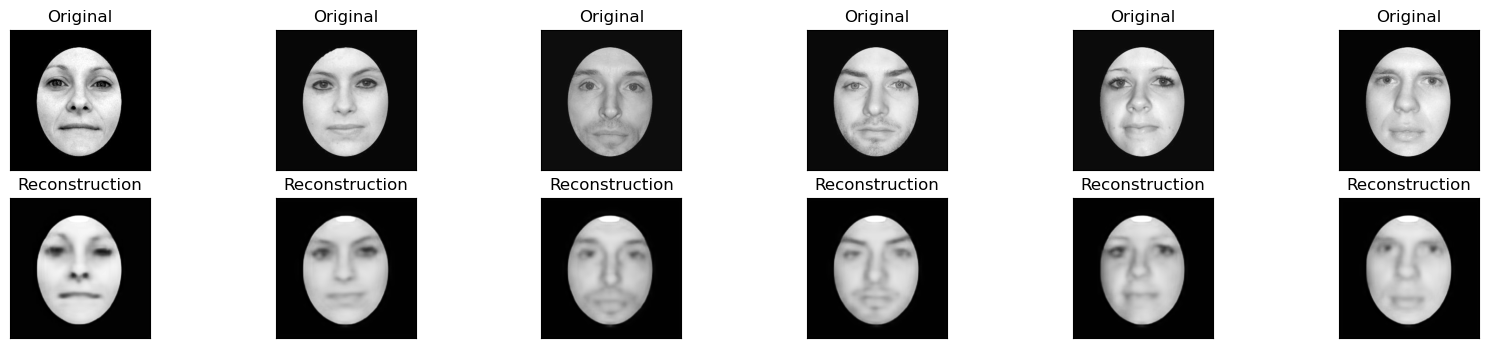

In [7]:
n = 6  # Number of images to display
plt.figure(figsize=(20, 4))

for i in range(n):
    # Afficher l'image originale
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(white[i].reshape(300, 300), cmap='gray')
    plt.title("Original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(pred[i].reshape(300, 300), cmap='gray')
    plt.title("Reconstruction")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [12]:
get_latent = keras.Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('latent_space').output)

In [13]:
latent_asian = get_latent.predict(trainset_asian, verbose=0)
latent_white = get_latent.predict(trainset_white, verbose=0)
latent_asian = latent_asian.reshape(50, -1)
latent_white = latent_white.reshape(50, -1)

asian_predict = autoencoder.predict(trainset_asian, verbose=0).reshape(50,300,300)
white_predict = autoencoder.predict(trainset_white, verbose=0).reshape(50,300,300)
asian = generator_to_array(trainset_asian).reshape(50,300,300)
white = generator_to_array(trainset_white).reshape(50,300,300)

asian_predict_flatten = asian_predict.reshape(50, -1)
white_predict_flatten = white_predict.reshape(50, -1)
asian_flatten = asian.reshape(50, -1)
white_flatten = white.reshape(50, -1)

test_asian = generator_to_array(testset_asian).reshape(6, 300, 300)
test_asian_predict = autoencoder.predict(testset_asian).reshape(6, 300, 300)
test_white = generator_to_array(testset_white).reshape(6, 300, 300)
test_white_predict = autoencoder.predict(testset_white).reshape(6, 300, 300)

1/1 [==============================] - 0s 98ms/step


In [ ]:
def mean_bhatta(latent_asian, latent_white):
    res = 0
    for i in range(len(latent_asian)):
        res += bhatta_coeff(latent_asian[i], latent_white[i])
        return res/len(latent_asian)

In [ ]:
def mean_bhatta_coeff(p, q):
    bhatta = 0
    if p.ndim == 1:
        for i in range(p.shape[0]):
            bhatta += np.sqrt((p[i] * q[i]))
        return bhatta
    else:
        for i in range(p.shape[0]):
            for j in range(p.shape[1]):
                bhatta += np.sqrt((p[i, j] * q[i, j]))
    return bhatta/p.shape[0]

In [ ]:
mean_bhatta_coeff(latent_asian_distrib, latent_white_distrib)

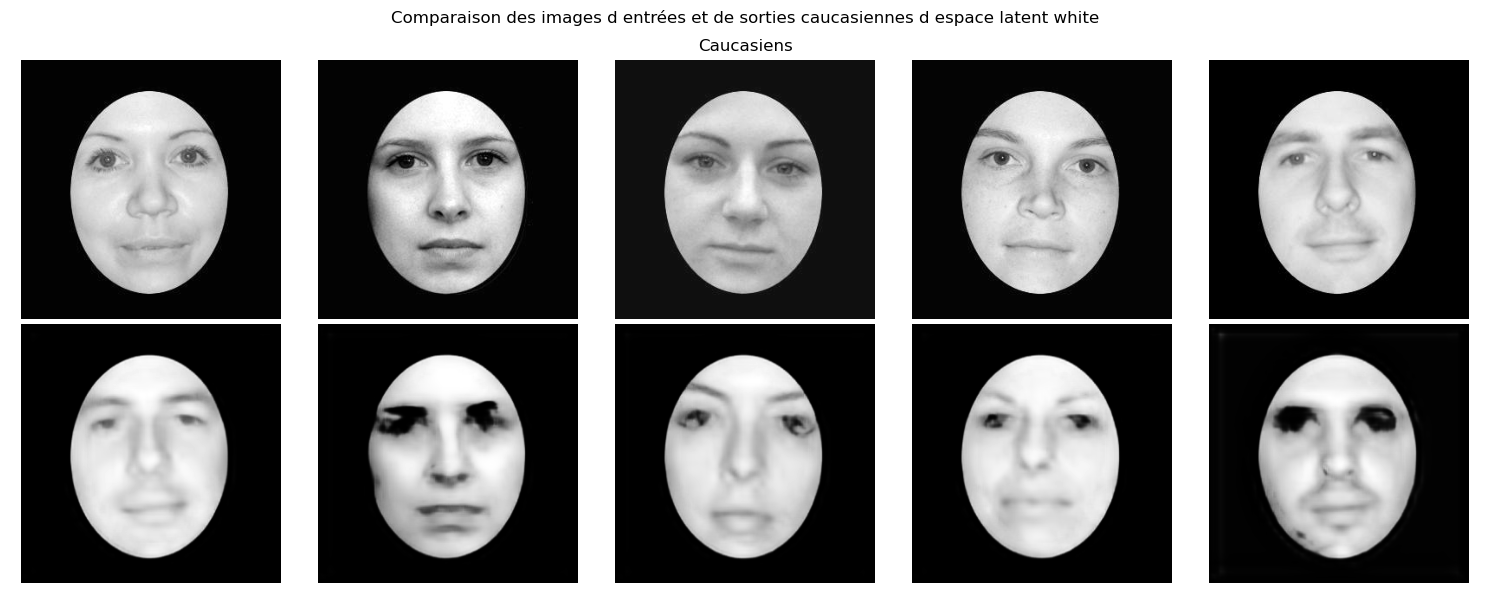

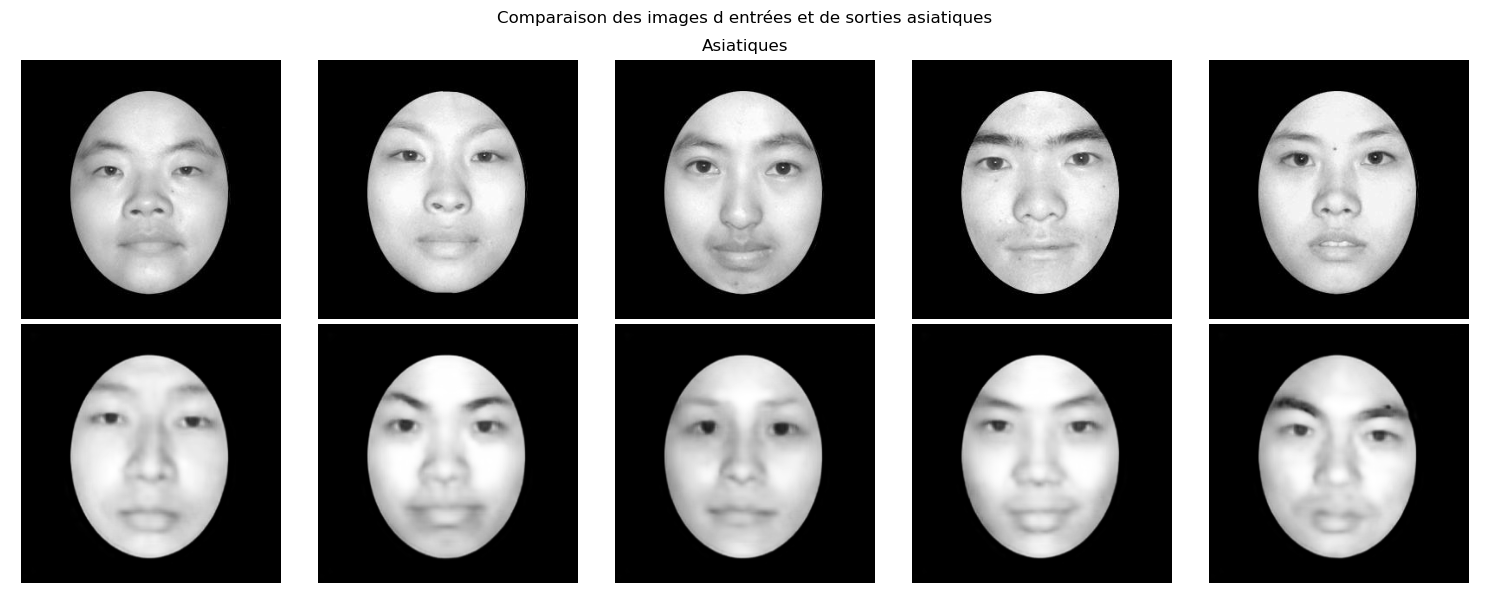

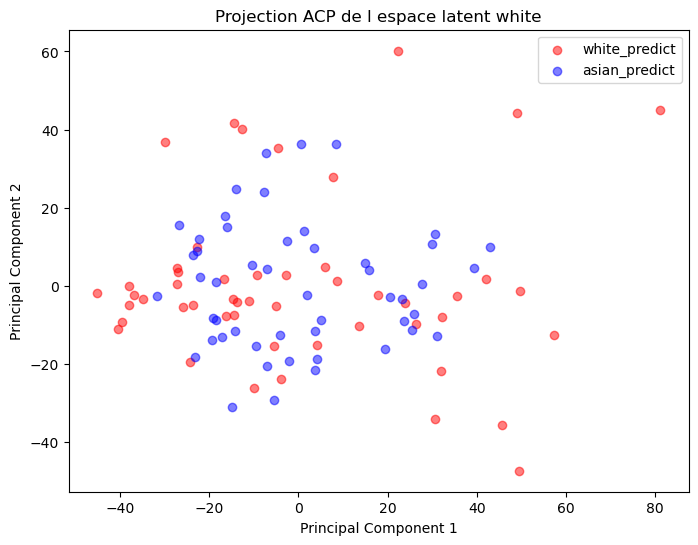

Moyenne des similarités cosinus pour les individus caucasiens : 0.9594077301025391
Moyenne des similarités cosinus pour les individus asiatiques : 0.9900396978855133
La similarité structurelle pour les caucasiens est de : 0.5615894841259906
La similarité structurelle pour les asiatiques est de : 0.8196839471932568
Moyenne des dispersions des espaces latents pour les individus caucasiens : 3238.648681640625
Moyenne des dispersions des espaces latents pour les individus asiatiques : 1637.3653564453125


In [14]:
comparaison_visages(asian, asian_predict, white, white_predict, "white")
latent_pca = pca(latent_asian, latent_white, "white")
cosinus_similarity(asian_flatten, asian_predict_flatten, white_flatten, white_predict_flatten)
print(f"La similarité structurelle pour les caucasiens est de : {ssim_mean(white, white_predict, 50)}")
print(f"La similarité structurelle pour les asiatiques est de : {ssim_mean(asian, asian_predict, 50)}")
comparaison_dispersion(latent_asian, latent_white)